In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df_train = pd.read_csv(r"C:\Users\RISHI MUKUNTHAN\Desktop\Data Science\Projects\Edwisor_Santander_Customer_Transaction\train.csv")
df_test = pd.read_csv(r"C:\Users\RISHI MUKUNTHAN\Desktop\Data Science\Projects\Edwisor_Santander_Customer_Transaction\test.csv")

In [4]:
df_train.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


# Balance Target Class

I am performing down sampling on the majority class in the training dataset to mitigate the effect of target class imbalance problem.

In [5]:
df_train['target'].value_counts()

0    179902
1     20098
Name: target, dtype: int64

#### UnderSampling the majority class

In [6]:
from sklearn.utils import resample

# Separate majority and minority classes
df_majority = df_train[df_train.target==0]
df_minority = df_train[df_train.target==1]
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=150000,
                                 random_state=42) # reproducible results

# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])

In [7]:
df_downsampled['target'].value_counts(normalize=True)

0    0.881845
1    0.118155
Name: target, dtype: float64

In [8]:
X = df_downsampled.iloc[:, 2:].values
y = df_downsampled.iloc[:, 1].values

In [9]:
from imblearn.over_sampling import RandomOverSampler

In [10]:
ros = RandomOverSampler(sampling_strategy={1:25000})
X_res, y_res = ros.fit_sample(X, y)

In [11]:
from collections import Counter
print(f"Original : {Counter(df_train['target'])}")
print(f"After Resampling : {Counter(y_res)}")

Original : Counter({0: 179902, 1: 20098})
After Resampling : Counter({0: 150000, 1: 25000})


In [14]:
pd.Series(y_res).value_counts(normalize=True)

0    0.857143
1    0.142857
dtype: float64

<AxesSubplot:xlabel='target', ylabel='count'>

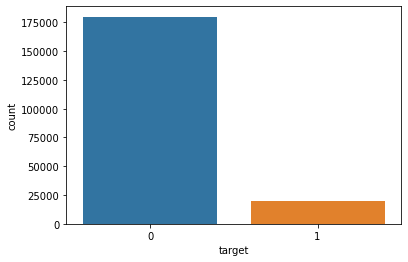

In [15]:
sns.countplot(df_train['target'])

<AxesSubplot:ylabel='count'>

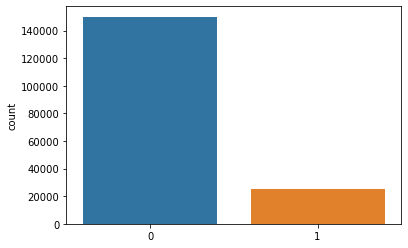

In [16]:
sns.countplot(y_res)

### Performing SMOTE(Synthetic Minority Oversampling TEchnique) for oversampling

Because of hardware limitations and SMOTE takes long time to perform oversampling. We are opting for simple random oversampling.

In [13]:
# X = df_downsampled.iloc[:, 2:].values
# y = df_downsampled.iloc[:, 1].values

In [14]:
# from imblearn.over_sampling import SMOTE
# smote = SMOTE()

In [15]:
# X_smote, y_smote = smote.fit_sample(X,y)

In [16]:
# from collections import Counter
# print(f"Before SMOTE : {Counter(y)}")
# print(f"After  SMOTE : {Counter(y_smote)}")

### Feature Scaling

In [17]:
from sklearn.preprocessing import  MinMaxScaler
mm=MinMaxScaler()
X_scaled=mm.fit_transform(X_res)

In [32]:
# from sklearn.preprocessing import StandardScaler
# mm=StandardScaler()
# X_scaled=mm.fit_transform(X_res)

## Dimensionality Reduction Using PCA

From our correlation analysis we know that there is no significant correlation within independent variables. Since, PCA performs dimentionality reduction by finding the directions/components of maximum variance in n-dimensional space and by reducing highly correlated features, we expect PCA to perform poorly and not give any meaningful results.

In [152]:
from sklearn.decomposition import PCA

pc=PCA(n_components=3)
data_pca=pc.fit(X_scaled)
variance_explained = sum(data_pca.explained_variance_ratio_)
print("Total variance explained by first 3 principal components: ",variance_explained)

Total variance explained by first 3 principal components:  0.020215547881851127


In [154]:
pc=PCA(n_components=150)
data_pca=pc.fit(X_scaled)
variance_explained = sum(data_pca.explained_variance_ratio_)
print("Total variance explained by first 150 principal components: ",variance_explained)

Total variance explained by first 150 principal components:  0.791890989469955


As we can see, the first 3 principal components barely explain 2 percent of variance in the data. Even with 150 PCs . we are unable to reach explained variance threshold of 80 percent. Performing PCA will only negatively affect the performance of our model in case of this dataset

# Train Test Split in the Training Dataset

In [18]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_res, test_size = 0.2, random_state = 0)

# Dimensionality Reduction Using LDA(Linear Discriminant Analysis)

In [126]:
#Under a minute
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda = LDA(n_components = None)
X_train_LD = lda.fit_transform(X_train,y_train)
X_test_LD = lda.transform(X_test)

In [66]:
# Create array of explained variance ratios
#lda_var_ratios = lda.explained_variance_ratio_

# Basic Logistic Regression Model

In [47]:
# Training the Logistic Regression model on the Training set. #Under a minute
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(penalty='l2',C=1, class_weight='balanced', random_state = 0)
classifier.fit(X_train, y_train)

LogisticRegression(C=1, class_weight='balanced', random_state=0)

In [70]:
# Making the Confusion Matrix - True(row), Pred(Column)
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
y_pred = classifier.predict(X_test)
y_score = classifier.predict_proba(X_test)
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix")
print(cm)
print(f"Accuracy:{accuracy_score(y_test, y_pred)}")
print(f"Area Under ROC curve: {roc_auc_score(y_test,y_score[:,1])}")

from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

Confusion Matrix
[[23409  6655]
 [ 1121  3815]]
Accuracy:0.7778285714285714
Area Under ROC curve: 0.8558202185957908
              precision    recall  f1-score   support

           0       0.95      0.78      0.86     30064
           1       0.36      0.77      0.50      4936

    accuracy                           0.78     35000
   macro avg       0.66      0.78      0.68     35000
weighted avg       0.87      0.78      0.81     35000



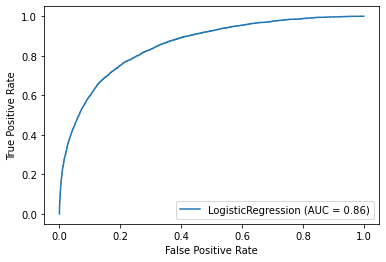

In [55]:
from sklearn.metrics import plot_roc_curve
plot_roc_curve(classifier, X_test, y_test)
plt.show()

Adding Class_Weight = Balanced improved the ROC_AUC. Recall for Class 1 was very low shows the effect of target class imbalance bias affecting the Logistic Regression model.

In [41]:
#pd.crosstab(y_test,y_pred)

In [29]:
# # Applying k-Fold Cross Validation
# from sklearn.model_selection import cross_val_score
# accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)
# print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
# print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

## Decision Tree Model

In [49]:
#Under 10 minutes
# Training the Decision Tree Classification model on the Training set
from sklearn.tree import DecisionTreeClassifier
DTclassifier = DecisionTreeClassifier(max_depth=30,criterion = 'gini', class_weight='balanced', random_state = 0)
DTclassifier.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=30, random_state=0)

In [73]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
y_pred = DTclassifier.predict(X_test)
y_score = DTclassifier.predict_proba(X_test)
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix")
print(cm)
print(f"Accuracy:{accuracy_score(y_test, y_pred)}")
print(f"Area Under ROC curve: {roc_auc_score(y_test,y_score[:,1])}")

from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

Confusion Matrix
[[26185  3879]
 [ 2635  2301]]
Accuracy:0.8138857142857143
Area Under ROC curve: 0.633588710777354
              precision    recall  f1-score   support

           0       0.91      0.87      0.89     30064
           1       0.37      0.47      0.41      4936

    accuracy                           0.81     35000
   macro avg       0.64      0.67      0.65     35000
weighted avg       0.83      0.81      0.82     35000



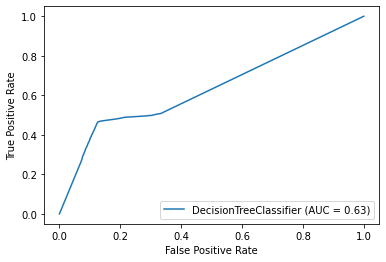

In [71]:
from sklearn.metrics import plot_roc_curve
plot_roc_curve(DTclassifier, X_test, y_test)
plt.show()

## Naive Bayes Model

In [44]:
#Under 2 minutes
# Training the Naive Bayes Classification model on the Training set
from sklearn.naive_bayes import GaussianNB
NBclassifier = GaussianNB()
NBclassifier.fit(X_train, y_train)

GaussianNB()

In [45]:
# from sklearn.ensemble import AdaBoostClassifier
# NBclassifier = AdaBoostClassifier(GaussianNB())
# NBclassifier.fit(X_train, y_train)

In [63]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
y_score = NBclassifier.predict_proba(X_test)
y_pred = (y_score[:,1] >= 0.3).astype(bool)
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix")
print(cm)
print(f"Accuracy:{accuracy_score(y_test, y_pred)}")
print(f"Area Under ROC curve: {roc_auc_score(y_test,y_score[:,1])}")

from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

Confusion Matrix
[[27691  2373]
 [ 1914  3022]]
Accuracy:0.8775142857142857
Area Under ROC curve: 0.8840590707948383
              precision    recall  f1-score   support

           0       0.94      0.92      0.93     30064
           1       0.56      0.61      0.59      4936

    accuracy                           0.88     35000
   macro avg       0.75      0.77      0.76     35000
weighted avg       0.88      0.88      0.88     35000



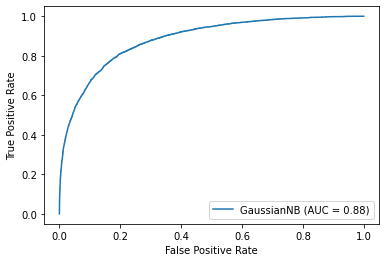

In [64]:
from sklearn.metrics import plot_roc_curve
plot_roc_curve(NBclassifier, X_test, y_test)
plt.show()

## Random Forest Model

In [127]:
#Under 10 minutes
# Training the Random Forest Classification model on the Training set
from sklearn.ensemble import RandomForestClassifier
RFclassifier = RandomForestClassifier(n_estimators = 100, max_depth=50, max_samples = 0.5,
                                      criterion = 'gini', class_weight='balanced', random_state = 0)
RFclassifier.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=50, max_samples=0.5,
                       random_state=0)

In [130]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
y_pred = RFclassifier.predict(X_test)
y_score = RFclassifier.predict_proba(X_test)
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix")
print(cm)
print(f"Accuracy:{accuracy_score(y_test, y_pred)}")
print(f"Area Under ROC curve: {roc_auc_score(y_test,y_score[:,1])}")

from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

Confusion Matrix
[[28228  1836]
 [ 2579  2357]]
Accuracy:0.8738571428571429
Area Under ROC curve: 0.857280781146089
              precision    recall  f1-score   support

           0       0.92      0.94      0.93     30064
           1       0.56      0.48      0.52      4936

    accuracy                           0.87     35000
   macro avg       0.74      0.71      0.72     35000
weighted avg       0.87      0.87      0.87     35000



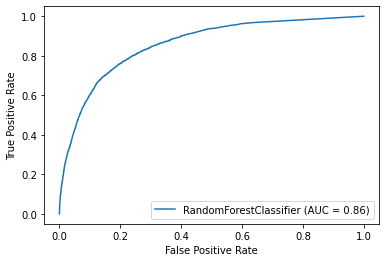

In [129]:
from sklearn.metrics import plot_roc_curve
plot_roc_curve(RFclassifier, X_test, y_test)
plt.show()

In [103]:
import time
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

X_train, y_train, X_valid, y_valid =  X_train, y_train, X_test, y_test

XGB_Classifier = XGBClassifier()

param_grid = {
        'max_depth': [6, 10, 20, 40], #Change based on no of features
        'learning_rate': [0.01, 0.05, 0.1, 0.2, 0,3],
        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bylevel': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'min_child_weight': [0.5, 1.0, 3.0, 5.0, 7.0, 10.0],
        'gamma': [0, 0.25, 0.5, 1.0],
        'reg_lambda': [0.1, 1.0, 5.0, 10.0, 50.0, 100.0],
        'n_estimators': [100,200]}

rs_clf = RandomizedSearchCV(XGB_Classifier,param_distributions=param_grid, n_iter=20,
                            n_jobs=1, verbose=2, cv=2,
                            scoring='roc_auc', refit=True, random_state=42)
print("Randomized search..")
search_time_start = time.time()
rs_clf.fit(X_train, y_train,eval_metric = 'auc',
              early_stopping_rounds = 10,
              eval_set = [(X_valid, y_valid)])
print("Randomized search time:", time.time() - search_time_start)

best_score = rs_clf.best_score_
best_params = rs_clf.best_params_
print("Best score: {}".format(best_score))
print("Best params: ")
for param_name in sorted(best_params.keys()):
    print('%s: %r' % (param_name, best_params[param_name]))

Randomized search..
Fitting 2 folds for each of 20 candidates, totalling 40 fits
[CV] subsample=0.7, reg_lambda=50.0, n_estimators=200, min_child_weight=1.0, max_depth=20, learning_rate=0, gamma=1.0, colsample_bytree=0.7, colsample_bylevel=0.5 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[0]	validation_0-auc:0.50000
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.50000
[2]	validation_0-auc:0.50000
[3]	validation_0-auc:0.50000
[4]	validation_0-auc:0.50000
[5]	validation_0-auc:0.50000
[6]	validation_0-auc:0.50000
[7]	validation_0-auc:0.50000
[8]	validation_0-auc:0.50000
[9]	validation_0-auc:0.50000
[10]	validation_0-auc:0.50000
Stopping. Best iteration:
[0]	validation_0-auc:0.50000

[CV]  subsample=0.7, reg_lambda=50.0, n_estimators=200, min_child_weight=1.0, max_depth=20, learning_rate=0, gamma=1.0, colsample_bytree=0.7, colsample_bylevel=0.5, total= 1.2min
[CV] subsample=0.7, reg_lambda=50.0, n_estimators=200, min_child_weight=1.0, max_depth=20, learning_rate=0, gamma=1.0, colsample_bytree=0.7, colsample_bylevel=0.5 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min remaining:    0.0s


[0]	validation_0-auc:0.50000
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.50000
[2]	validation_0-auc:0.50000
[3]	validation_0-auc:0.50000
[4]	validation_0-auc:0.50000
[5]	validation_0-auc:0.50000
[6]	validation_0-auc:0.50000
[7]	validation_0-auc:0.50000
[8]	validation_0-auc:0.50000
[9]	validation_0-auc:0.50000
[10]	validation_0-auc:0.50000
Stopping. Best iteration:
[0]	validation_0-auc:0.50000

[CV]  subsample=0.7, reg_lambda=50.0, n_estimators=200, min_child_weight=1.0, max_depth=20, learning_rate=0, gamma=1.0, colsample_bytree=0.7, colsample_bylevel=0.5, total= 1.2min
[CV] subsample=0.6, reg_lambda=1.0, n_estimators=200, min_child_weight=5.0, max_depth=10, learning_rate=0, gamma=0, colsample_bytree=0.9, colsample_bylevel=0.7 
[0]	validation_0-auc:0.50000
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.50000
[2]	validation_0-auc:0.50000
[3]	validation_0-auc:0.50000
[4]	validation_0-auc:0.50000
[5]	validat

[141]	validation_0-auc:0.88216
[142]	validation_0-auc:0.88233
[143]	validation_0-auc:0.88253
[144]	validation_0-auc:0.88261
[145]	validation_0-auc:0.88258
[146]	validation_0-auc:0.88277
[147]	validation_0-auc:0.88299
[148]	validation_0-auc:0.88299
[149]	validation_0-auc:0.88311
[150]	validation_0-auc:0.88322
[151]	validation_0-auc:0.88335
[152]	validation_0-auc:0.88352
[153]	validation_0-auc:0.88362
[154]	validation_0-auc:0.88373
[155]	validation_0-auc:0.88380
[156]	validation_0-auc:0.88391
[157]	validation_0-auc:0.88396
[158]	validation_0-auc:0.88403
[159]	validation_0-auc:0.88409
[160]	validation_0-auc:0.88430
[161]	validation_0-auc:0.88447
[162]	validation_0-auc:0.88457
[163]	validation_0-auc:0.88466
[164]	validation_0-auc:0.88470
[165]	validation_0-auc:0.88482
[166]	validation_0-auc:0.88495
[167]	validation_0-auc:0.88504
[168]	validation_0-auc:0.88519
[169]	validation_0-auc:0.88527
[170]	validation_0-auc:0.88540
[171]	validation_0-auc:0.88560
[172]	validation_0-auc:0.88576
[173]	va

[196]	validation_0-auc:0.88919
[197]	validation_0-auc:0.88926
[198]	validation_0-auc:0.88930
[199]	validation_0-auc:0.88938
[CV]  subsample=0.9, reg_lambda=1.0, n_estimators=200, min_child_weight=0.5, max_depth=20, learning_rate=0.1, gamma=0, colsample_bytree=0.9, colsample_bylevel=1.0, total=47.9min
[CV] subsample=0.7, reg_lambda=5.0, n_estimators=200, min_child_weight=10.0, max_depth=40, learning_rate=3, gamma=0, colsample_bytree=0.5, colsample_bylevel=0.6 
[0]	validation_0-auc:0.65631
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.64971
[2]	validation_0-auc:0.63176
[3]	validation_0-auc:0.53862
[4]	validation_0-auc:0.49101
[5]	validation_0-auc:0.47570
[6]	validation_0-auc:0.50000
[7]	validation_0-auc:0.47672
[8]	validation_0-auc:0.50000
[9]	validation_0-auc:0.49947
[10]	validation_0-auc:0.50000
Stopping. Best iteration:
[0]	validation_0-auc:0.65631

[CV]  subsample=0.7, reg_lambda=5.0, n_estimators=200, min_child_weight=10.0, max_depth=40, lear

[199]	validation_0-auc:0.87697
[CV]  subsample=0.5, reg_lambda=0.1, n_estimators=200, min_child_weight=1.0, max_depth=40, learning_rate=0.2, gamma=0.5, colsample_bytree=0.7, colsample_bylevel=0.5, total=16.8min
[CV] subsample=0.5, reg_lambda=0.1, n_estimators=200, min_child_weight=1.0, max_depth=40, learning_rate=0.2, gamma=0.5, colsample_bytree=0.7, colsample_bylevel=0.5 
[0]	validation_0-auc:0.59102
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.64303
[2]	validation_0-auc:0.67922
[3]	validation_0-auc:0.69796
[4]	validation_0-auc:0.71821
[5]	validation_0-auc:0.73614
[6]	validation_0-auc:0.74709
[7]	validation_0-auc:0.75723
[8]	validation_0-auc:0.76478
[9]	validation_0-auc:0.77079
[10]	validation_0-auc:0.77540
[11]	validation_0-auc:0.78089
[12]	validation_0-auc:0.78726
[13]	validation_0-auc:0.79063
[14]	validation_0-auc:0.79419
[15]	validation_0-auc:0.79679
[16]	validation_0-auc:0.80114
[17]	validation_0-auc:0.80440
[18]	validation_0-auc:0.80579


[43]	validation_0-auc:0.86303
[44]	validation_0-auc:0.86378
[45]	validation_0-auc:0.86449
[46]	validation_0-auc:0.86501
[47]	validation_0-auc:0.86515
[48]	validation_0-auc:0.86556
[49]	validation_0-auc:0.86601
[50]	validation_0-auc:0.86659
[51]	validation_0-auc:0.86740
[52]	validation_0-auc:0.86761
[53]	validation_0-auc:0.86802
[54]	validation_0-auc:0.86846
[55]	validation_0-auc:0.86892
[56]	validation_0-auc:0.86943
[57]	validation_0-auc:0.86969
[58]	validation_0-auc:0.86994
[59]	validation_0-auc:0.86995
[60]	validation_0-auc:0.87045
[61]	validation_0-auc:0.87063
[62]	validation_0-auc:0.87080
[63]	validation_0-auc:0.87140
[64]	validation_0-auc:0.87188
[65]	validation_0-auc:0.87212
[66]	validation_0-auc:0.87225
[67]	validation_0-auc:0.87274
[68]	validation_0-auc:0.87308
[69]	validation_0-auc:0.87313
[70]	validation_0-auc:0.87346
[71]	validation_0-auc:0.87345
[72]	validation_0-auc:0.87383
[73]	validation_0-auc:0.87388
[74]	validation_0-auc:0.87423
[75]	validation_0-auc:0.87420
[76]	valid

[90]	validation_0-auc:0.88490
[91]	validation_0-auc:0.88507
[92]	validation_0-auc:0.88537
[93]	validation_0-auc:0.88552
[94]	validation_0-auc:0.88564
[95]	validation_0-auc:0.88570
[96]	validation_0-auc:0.88584
[97]	validation_0-auc:0.88615
[98]	validation_0-auc:0.88624
[99]	validation_0-auc:0.88640
[100]	validation_0-auc:0.88654
[101]	validation_0-auc:0.88666
[102]	validation_0-auc:0.88685
[103]	validation_0-auc:0.88714
[104]	validation_0-auc:0.88739
[105]	validation_0-auc:0.88760
[106]	validation_0-auc:0.88786
[107]	validation_0-auc:0.88815
[108]	validation_0-auc:0.88823
[109]	validation_0-auc:0.88835
[110]	validation_0-auc:0.88859
[111]	validation_0-auc:0.88859
[112]	validation_0-auc:0.88868
[113]	validation_0-auc:0.88882
[114]	validation_0-auc:0.88897
[115]	validation_0-auc:0.88916
[116]	validation_0-auc:0.88938
[117]	validation_0-auc:0.88941
[118]	validation_0-auc:0.88953
[119]	validation_0-auc:0.88954
[120]	validation_0-auc:0.88973
[121]	validation_0-auc:0.88991
[122]	validation_0

[145]	validation_0-auc:0.89107
[146]	validation_0-auc:0.89106
[147]	validation_0-auc:0.89116
[148]	validation_0-auc:0.89120
[149]	validation_0-auc:0.89138
[150]	validation_0-auc:0.89153
[151]	validation_0-auc:0.89163
[152]	validation_0-auc:0.89175
[153]	validation_0-auc:0.89186
[154]	validation_0-auc:0.89182
[155]	validation_0-auc:0.89194
[156]	validation_0-auc:0.89184
[157]	validation_0-auc:0.89183
[158]	validation_0-auc:0.89189
[159]	validation_0-auc:0.89196
[160]	validation_0-auc:0.89194
[161]	validation_0-auc:0.89201
[162]	validation_0-auc:0.89208
[163]	validation_0-auc:0.89219
[164]	validation_0-auc:0.89235
[165]	validation_0-auc:0.89237
[166]	validation_0-auc:0.89244
[167]	validation_0-auc:0.89248
[168]	validation_0-auc:0.89252
[169]	validation_0-auc:0.89249
[170]	validation_0-auc:0.89261
[171]	validation_0-auc:0.89274
[172]	validation_0-auc:0.89276
[173]	validation_0-auc:0.89289
[174]	validation_0-auc:0.89299
[175]	validation_0-auc:0.89302
[176]	validation_0-auc:0.89310
[177]	va

[90]	validation_0-auc:0.85156
[91]	validation_0-auc:0.85198
[92]	validation_0-auc:0.85226
[93]	validation_0-auc:0.85281
[94]	validation_0-auc:0.85337
[95]	validation_0-auc:0.85377
[96]	validation_0-auc:0.85417
[97]	validation_0-auc:0.85451
[98]	validation_0-auc:0.85498
[99]	validation_0-auc:0.85517
[CV]  subsample=0.8, reg_lambda=100.0, n_estimators=100, min_child_weight=10.0, max_depth=10, learning_rate=0.05, gamma=0.25, colsample_bytree=0.8, colsample_bylevel=0.5, total= 5.6min
[CV] subsample=0.7, reg_lambda=50.0, n_estimators=100, min_child_weight=5.0, max_depth=20, learning_rate=0.1, gamma=0, colsample_bytree=0.5, colsample_bylevel=0.9 
[0]	validation_0-auc:0.59380
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.66820
[2]	validation_0-auc:0.70042
[3]	validation_0-auc:0.73138
[4]	validation_0-auc:0.75089
[5]	validation_0-auc:0.76538
[6]	validation_0-auc:0.77514
[7]	validation_0-auc:0.78037
[8]	validation_0-auc:0.78595
[9]	validation_0-auc:0.793

[24]	validation_0-auc:0.84221
[25]	validation_0-auc:0.84407
[26]	validation_0-auc:0.84507
[27]	validation_0-auc:0.84720
[28]	validation_0-auc:0.84895
[29]	validation_0-auc:0.84951
[30]	validation_0-auc:0.85062
[31]	validation_0-auc:0.85159
[32]	validation_0-auc:0.85287
[33]	validation_0-auc:0.85398
[34]	validation_0-auc:0.85527
[35]	validation_0-auc:0.85575
[36]	validation_0-auc:0.85662
[37]	validation_0-auc:0.85723
[38]	validation_0-auc:0.85812
[39]	validation_0-auc:0.85929
[40]	validation_0-auc:0.85982
[41]	validation_0-auc:0.86047
[42]	validation_0-auc:0.86105
[43]	validation_0-auc:0.86210
[44]	validation_0-auc:0.86272
[45]	validation_0-auc:0.86357
[46]	validation_0-auc:0.86382
[47]	validation_0-auc:0.86425
[48]	validation_0-auc:0.86542
[49]	validation_0-auc:0.86594
[50]	validation_0-auc:0.86659
[51]	validation_0-auc:0.86695
[52]	validation_0-auc:0.86713
[53]	validation_0-auc:0.86755
[54]	validation_0-auc:0.86788
[55]	validation_0-auc:0.86799
[56]	validation_0-auc:0.86824
[57]	valid

[81]	validation_0-auc:0.87591
[82]	validation_0-auc:0.87610
[83]	validation_0-auc:0.87645
[84]	validation_0-auc:0.87666
[85]	validation_0-auc:0.87694
[86]	validation_0-auc:0.87710
[87]	validation_0-auc:0.87712
[88]	validation_0-auc:0.87732
[89]	validation_0-auc:0.87747
[90]	validation_0-auc:0.87758
[91]	validation_0-auc:0.87780
[92]	validation_0-auc:0.87796
[93]	validation_0-auc:0.87816
[94]	validation_0-auc:0.87832
[95]	validation_0-auc:0.87842
[96]	validation_0-auc:0.87866
[97]	validation_0-auc:0.87880
[98]	validation_0-auc:0.87897
[99]	validation_0-auc:0.87917
[100]	validation_0-auc:0.87920
[101]	validation_0-auc:0.87939
[102]	validation_0-auc:0.87941
[103]	validation_0-auc:0.87975
[104]	validation_0-auc:0.87995
[105]	validation_0-auc:0.88004
[106]	validation_0-auc:0.88010
[107]	validation_0-auc:0.88028
[108]	validation_0-auc:0.88035
[109]	validation_0-auc:0.88052
[110]	validation_0-auc:0.88074
[111]	validation_0-auc:0.88074
[112]	validation_0-auc:0.88090
[113]	validation_0-auc:0.88

[25]	validation_0-auc:0.73812
[26]	validation_0-auc:0.74037
[27]	validation_0-auc:0.74077
[28]	validation_0-auc:0.74077
[29]	validation_0-auc:0.74077
[30]	validation_0-auc:0.74242
[31]	validation_0-auc:0.74271
[32]	validation_0-auc:0.74263
[33]	validation_0-auc:0.74354
[34]	validation_0-auc:0.74379
[35]	validation_0-auc:0.74366
[36]	validation_0-auc:0.74414
[37]	validation_0-auc:0.74483
[38]	validation_0-auc:0.74573
[39]	validation_0-auc:0.74627
[40]	validation_0-auc:0.74652
[41]	validation_0-auc:0.74739
[42]	validation_0-auc:0.74701
[43]	validation_0-auc:0.74821
[44]	validation_0-auc:0.74871
[45]	validation_0-auc:0.74854
[46]	validation_0-auc:0.74869
[47]	validation_0-auc:0.74965
[48]	validation_0-auc:0.75034
[49]	validation_0-auc:0.75062
[50]	validation_0-auc:0.75120
[51]	validation_0-auc:0.75179
[52]	validation_0-auc:0.75169
[53]	validation_0-auc:0.75233
[54]	validation_0-auc:0.75292
[55]	validation_0-auc:0.75324
[56]	validation_0-auc:0.75310
[57]	validation_0-auc:0.75364
[58]	valid

[132]	validation_0-auc:0.89418
[133]	validation_0-auc:0.89417
[134]	validation_0-auc:0.89428
[135]	validation_0-auc:0.89435
[136]	validation_0-auc:0.89446
[137]	validation_0-auc:0.89464
[138]	validation_0-auc:0.89466
[139]	validation_0-auc:0.89457
[140]	validation_0-auc:0.89466
[141]	validation_0-auc:0.89471
[142]	validation_0-auc:0.89474
[143]	validation_0-auc:0.89473
[144]	validation_0-auc:0.89475
[145]	validation_0-auc:0.89483
[146]	validation_0-auc:0.89483
[147]	validation_0-auc:0.89494
[148]	validation_0-auc:0.89499
[149]	validation_0-auc:0.89498
[150]	validation_0-auc:0.89506
[151]	validation_0-auc:0.89512
[152]	validation_0-auc:0.89523
[153]	validation_0-auc:0.89524
[154]	validation_0-auc:0.89526
[155]	validation_0-auc:0.89546
[156]	validation_0-auc:0.89553
[157]	validation_0-auc:0.89555
[158]	validation_0-auc:0.89571
[159]	validation_0-auc:0.89576
[160]	validation_0-auc:0.89579
[161]	validation_0-auc:0.89583
[162]	validation_0-auc:0.89589
[163]	validation_0-auc:0.89585
[164]	va

[187]	validation_0-auc:0.89513
[188]	validation_0-auc:0.89521
[189]	validation_0-auc:0.89536
[190]	validation_0-auc:0.89539
[191]	validation_0-auc:0.89546
[192]	validation_0-auc:0.89560
[193]	validation_0-auc:0.89564
[194]	validation_0-auc:0.89571
[195]	validation_0-auc:0.89571
[196]	validation_0-auc:0.89576
[197]	validation_0-auc:0.89579
[198]	validation_0-auc:0.89580
[199]	validation_0-auc:0.89575
[CV]  subsample=1.0, reg_lambda=100.0, n_estimators=200, min_child_weight=0.5, max_depth=20, learning_rate=0.2, gamma=1.0, colsample_bytree=1.0, colsample_bylevel=0.9, total=57.0min
[CV] subsample=0.6, reg_lambda=100.0, n_estimators=100, min_child_weight=10.0, max_depth=40, learning_rate=0, gamma=0.5, colsample_bytree=0.5, colsample_bylevel=0.6 
[0]	validation_0-auc:0.50000
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.50000
[2]	validation_0-auc:0.50000
[3]	validation_0-auc:0.50000
[4]	validation_0-auc:0.50000
[5]	validation_0-auc:0.50000
[6]	validat

[38]	validation_0-auc:0.83937
[39]	validation_0-auc:0.84012
[40]	validation_0-auc:0.84120
[41]	validation_0-auc:0.84204
[42]	validation_0-auc:0.84304
[43]	validation_0-auc:0.84390
[44]	validation_0-auc:0.84518
[45]	validation_0-auc:0.84605
[46]	validation_0-auc:0.84678
[47]	validation_0-auc:0.84706
[48]	validation_0-auc:0.84805
[49]	validation_0-auc:0.84905
[50]	validation_0-auc:0.85061
[51]	validation_0-auc:0.85112
[52]	validation_0-auc:0.85165
[53]	validation_0-auc:0.85258
[54]	validation_0-auc:0.85350
[55]	validation_0-auc:0.85401
[56]	validation_0-auc:0.85507
[57]	validation_0-auc:0.85584
[58]	validation_0-auc:0.85651
[59]	validation_0-auc:0.85673
[60]	validation_0-auc:0.85713
[61]	validation_0-auc:0.85735
[62]	validation_0-auc:0.85839
[63]	validation_0-auc:0.85925
[64]	validation_0-auc:0.85970
[65]	validation_0-auc:0.86058
[66]	validation_0-auc:0.86126
[67]	validation_0-auc:0.86196
[68]	validation_0-auc:0.86241
[69]	validation_0-auc:0.86299
[70]	validation_0-auc:0.86347
[71]	valid

[95]	validation_0-auc:0.87626
[96]	validation_0-auc:0.87635
[97]	validation_0-auc:0.87691
[98]	validation_0-auc:0.87716
[99]	validation_0-auc:0.87732
[100]	validation_0-auc:0.87755
[101]	validation_0-auc:0.87795
[102]	validation_0-auc:0.87816
[103]	validation_0-auc:0.87818
[104]	validation_0-auc:0.87848
[105]	validation_0-auc:0.87876
[106]	validation_0-auc:0.87878
[107]	validation_0-auc:0.87916
[108]	validation_0-auc:0.87944
[109]	validation_0-auc:0.87974
[110]	validation_0-auc:0.88008
[111]	validation_0-auc:0.88018
[112]	validation_0-auc:0.88054
[113]	validation_0-auc:0.88087
[114]	validation_0-auc:0.88116
[115]	validation_0-auc:0.88124
[116]	validation_0-auc:0.88149
[117]	validation_0-auc:0.88188
[118]	validation_0-auc:0.88208
[119]	validation_0-auc:0.88228
[120]	validation_0-auc:0.88240
[121]	validation_0-auc:0.88245
[122]	validation_0-auc:0.88271
[123]	validation_0-auc:0.88280
[124]	validation_0-auc:0.88294
[125]	validation_0-auc:0.88313
[126]	validation_0-auc:0.88325
[127]	validat

[42]	validation_0-auc:0.79981
[43]	validation_0-auc:0.80085
[44]	validation_0-auc:0.80108
[45]	validation_0-auc:0.80244
[46]	validation_0-auc:0.80360
[47]	validation_0-auc:0.80451
[48]	validation_0-auc:0.80617
[49]	validation_0-auc:0.80734
[50]	validation_0-auc:0.80929
[51]	validation_0-auc:0.81004
[52]	validation_0-auc:0.81114
[53]	validation_0-auc:0.81207
[54]	validation_0-auc:0.81334
[55]	validation_0-auc:0.81340
[56]	validation_0-auc:0.81495
[57]	validation_0-auc:0.81636
[58]	validation_0-auc:0.81701
[59]	validation_0-auc:0.81755
[60]	validation_0-auc:0.81826
[61]	validation_0-auc:0.81956
[62]	validation_0-auc:0.82099
[63]	validation_0-auc:0.82151
[64]	validation_0-auc:0.82258
[65]	validation_0-auc:0.82341
[66]	validation_0-auc:0.82385
[67]	validation_0-auc:0.82450
[68]	validation_0-auc:0.82479
[69]	validation_0-auc:0.82574
[70]	validation_0-auc:0.82595
[71]	validation_0-auc:0.82671
[72]	validation_0-auc:0.82774
[73]	validation_0-auc:0.82833
[74]	validation_0-auc:0.82855
[75]	valid

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed: 475.9min finished


[0]	validation_0-auc:0.67004
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.71106
[2]	validation_0-auc:0.74069
[3]	validation_0-auc:0.76375
[4]	validation_0-auc:0.77833
[5]	validation_0-auc:0.79127
[6]	validation_0-auc:0.80034
[7]	validation_0-auc:0.80899
[8]	validation_0-auc:0.81811
[9]	validation_0-auc:0.82537
[10]	validation_0-auc:0.83108
[11]	validation_0-auc:0.83609
[12]	validation_0-auc:0.84129
[13]	validation_0-auc:0.84671
[14]	validation_0-auc:0.84937
[15]	validation_0-auc:0.85330
[16]	validation_0-auc:0.85648
[17]	validation_0-auc:0.86010
[18]	validation_0-auc:0.86326
[19]	validation_0-auc:0.86598
[20]	validation_0-auc:0.86830
[21]	validation_0-auc:0.87040
[22]	validation_0-auc:0.87228
[23]	validation_0-auc:0.87399
[24]	validation_0-auc:0.87566
[25]	validation_0-auc:0.87656
[26]	validation_0-auc:0.87824
[27]	validation_0-auc:0.87937
[28]	validation_0-auc:0.88088
[29]	validation_0-auc:0.88167
[30]	validation_0-auc:0.88308
[31]	validation_

In [132]:
#Under 120 minutes Original with 200 variables
# Training XGBoost on the Training set
from xgboost import XGBClassifier
XGB_classifier = XGBClassifier(n_estimators=200, subsample=1, learning_rate=0.2, gamma=1,
                               max_depth=20, min_child_weight=0.5, reg_alpha=0, reg_lambda=100,
                               colsample_bylevel=0.9, colsample_bytree=1, scale_pos_weight=6)
eval_set = [(X_test, y_test)]
XGB_classifier.fit(X_train, y_train,eval_metric="auc", eval_set=eval_set, early_stopping_rounds = 5, verbose=2)

[0]	validation_0-auc:0.71420
Will train until validation_0-auc hasn't improved in 5 rounds.
[2]	validation_0-auc:0.77911
[4]	validation_0-auc:0.80909
[6]	validation_0-auc:0.82840
[8]	validation_0-auc:0.84015
[10]	validation_0-auc:0.84945
[12]	validation_0-auc:0.85725
[14]	validation_0-auc:0.86290
[16]	validation_0-auc:0.86723
[18]	validation_0-auc:0.87150
[20]	validation_0-auc:0.87527
[22]	validation_0-auc:0.87789
[24]	validation_0-auc:0.88045
[26]	validation_0-auc:0.88254
[28]	validation_0-auc:0.88450
[30]	validation_0-auc:0.88595
[32]	validation_0-auc:0.88709
[34]	validation_0-auc:0.88884
[36]	validation_0-auc:0.88996
[38]	validation_0-auc:0.89145
[40]	validation_0-auc:0.89240
[42]	validation_0-auc:0.89342
[44]	validation_0-auc:0.89404
[46]	validation_0-auc:0.89483
[48]	validation_0-auc:0.89552
[50]	validation_0-auc:0.89642
[52]	validation_0-auc:0.89687
[54]	validation_0-auc:0.89765
[56]	validation_0-auc:0.89860
[58]	validation_0-auc:0.89904
[60]	validation_0-auc:0.89971
[62]	validat

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.9,
              colsample_bynode=1, colsample_bytree=1, gamma=1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=20,
              min_child_weight=0.5, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=100, scale_pos_weight=6, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [108]:
import joblib
joblib.dump(XGB_classifier,'XGB_Model_80_20.pkl')

['XGB_Model_80_20.pkl']

In [133]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
y_pred = XGB_classifier.predict(X_test)
y_score = XGB_classifier.predict_proba(X_test)
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix")
print(cm)
print(f"Accuracy:{accuracy_score(y_test, y_pred)}")
print(f"Area Under ROC curve: {roc_auc_score(y_test,y_score[:,1])}")

from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

Confusion Matrix
[[29295   769]
 [ 2093  2843]]
Accuracy:0.9182285714285714
Area Under ROC curve: 0.9140744646159505
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     30064
           1       0.79      0.58      0.67      4936

    accuracy                           0.92     35000
   macro avg       0.86      0.78      0.81     35000
weighted avg       0.91      0.92      0.91     35000



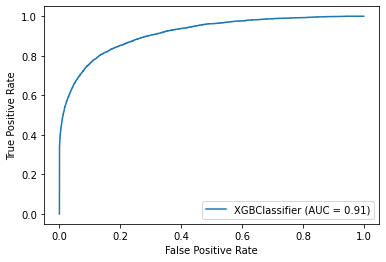

In [134]:
from sklearn.metrics import plot_roc_curve
plot_roc_curve(XGB_classifier, X_test, y_test)
plt.show()

In [119]:
#After LDA with 1 variable
# Training XGBoost on the Training set
from xgboost import XGBClassifier
XGB_classifier = XGBClassifier(n_estimators=200, subsample=1, learning_rate=0.2, gamma=1,
                               max_depth=20, min_child_weight=0.5, reg_alpha=0, reg_lambda=100,
                               colsample_bylevel=0.9, colsample_bytree=1)
eval_set = [(X_test, y_test)]
XGB_classifier.fit(X_train, y_train,eval_metric="auc", eval_set=eval_set, early_stopping_rounds = 5, verbose=2)

[0]	validation_0-auc:0.81856
Will train until validation_0-auc hasn't improved in 5 rounds.
[2]	validation_0-auc:0.84642
[4]	validation_0-auc:0.84794
[6]	validation_0-auc:0.84803
[8]	validation_0-auc:0.85272
[10]	validation_0-auc:0.85476
[12]	validation_0-auc:0.85486
[14]	validation_0-auc:0.85494
[16]	validation_0-auc:0.85555
[18]	validation_0-auc:0.85589
[20]	validation_0-auc:0.85603
[22]	validation_0-auc:0.85610
[24]	validation_0-auc:0.85625
[26]	validation_0-auc:0.85635
[28]	validation_0-auc:0.85637
[30]	validation_0-auc:0.85634
[32]	validation_0-auc:0.85637
[34]	validation_0-auc:0.85644
[36]	validation_0-auc:0.85649
[38]	validation_0-auc:0.85650
[40]	validation_0-auc:0.85651
[42]	validation_0-auc:0.85654
[44]	validation_0-auc:0.85654
[46]	validation_0-auc:0.85654
Stopping. Best iteration:
[41]	validation_0-auc:0.85654



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.9,
              colsample_bynode=1, colsample_bytree=1, gamma=1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=20,
              min_child_weight=0.5, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=100, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [120]:
# Making the Confusion Matrix for LDA model
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
y_pred = XGB_classifier.predict(X_test)
y_score = XGB_classifier.predict_proba(X_test)
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix")
print(cm)
print(f"Accuracy:{accuracy_score(y_test, y_pred)}")
print(f"Area Under ROC curve: {roc_auc_score(y_test,y_score[:,1])}")

from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

Confusion Matrix
[[29203   861]
 [ 3162  1774]]
Accuracy:0.8850571428571429
Area Under ROC curve: 0.8565396724157561
              precision    recall  f1-score   support

           0       0.90      0.97      0.94     30064
           1       0.67      0.36      0.47      4936

    accuracy                           0.89     35000
   macro avg       0.79      0.67      0.70     35000
weighted avg       0.87      0.89      0.87     35000



## Retrain on the whole resampled dataset before splitting and predict for test data

In [123]:
X_test_final = df_test.iloc[:, 1:].values

In [124]:
X_test_final.shape

(200000, 200)

In [112]:
X_test_final=mm.transform(X_test_final)

In [109]:
# Training XGBoost on the Training set
from xgboost import XGBClassifier
XGB_classifier = XGBClassifier()
XGB_classifier.fit(X_scaled, y_res)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [113]:
y_pred = XGB_classifier.predict(X_test_final)
y_score = XGB_classifier.predict_proba(X_test_final)
df_test_submit = df_test['ID_code']
df_test_submit = pd.concat([df_test_submit,pd.Series(y_score[:,1])], axis=1)
df_test_submit.columns =['ID_code','target']
df_test_submit.to_csv('XGBoost_Submission.csv', index=False)

In [114]:
df_check = pd.read_csv(r"C:\Users\RISHI MUKUNTHAN\Desktop\Data Science\Projects\Edwisor_Santander_Customer_Transaction\Python Development\XGBoost_Submission.csv")

In [115]:
df_check.head()

,ID_code,target
0,test_0,0.151641
1,test_1,0.170378
2,test_2,0.160630
3,test_3,0.204426
4,test_4,0.013597
